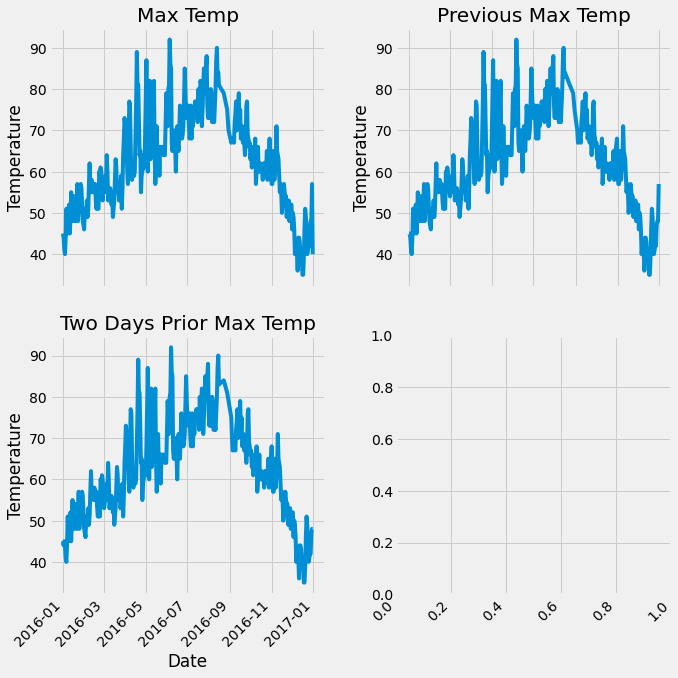

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

# 加入下述代码！可能！是因为torch包中包含了名为libiomp5md.dll的文件，
# 与Anaconda环境中的同一个文件出现了某种冲突，所以需要删除一个。
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

features = pd.read_csv('data2.csv')

# 处理时间数据
import datetime

# 分别得到年，月，日
years = features['year']
months = features['month']
days = features['day']

# datetime格式
dates = [
    str(int(year)) + '-' + str(int(month)) + '-' + str(int(day))
    for year, month, day in zip(years, months, days)
]

# datetime模块的datetime对象提供的strptime方法可以将字符串转为datetime对象，转换时要求字符串内容符合指定的格式。
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 准备画图
# 指定默认风格
plt.style.use('fivethirtyeight')

# 设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,
                                             ncols=2,
                                             figsize=(10, 10))
fig.autofmt_xdate(rotation=45)

# 标签值
ax1.plot(dates, features['actual']) # 所用数据列
ax1.set_xlabel('') # x轴数据
ax1.set_ylabel('Temperature') # y轴数据
ax1.set_title('Max Temp') # 图表标题

# 昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel('')
ax2.set_ylabel('Temperature')
ax2.set_title('Previous Max Temp')

# 前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date')
ax3.set_ylabel('Temperature')
ax3.set_title('Two Days Prior Max Temp')


plt.tight_layout(pad=2)

In [7]:
# 独热编码（字符串数据转为数值形式）
features = pd.get_dummies(features)

# 标签
labels = np.array(features['actual'])

# 在特征中去掉标签
# axis = 1 表示沿着每一行或者列标签横向执行对应的方法
# https://blog.csdn.net/wyf2017/article/details/107459509
features = features.drop('actual', axis=1)

# 每列的名字单独保存一下，以备后患
feature_list = list(features.columns)

# 转换成合适的格式
# np.array()把列表转化为数组
features = np.array(features)

from sklearn import preprocessing

# 不仅计算训练数据的均值和方差，还会基于计算出来的均值和方差来转换训练数据，从而把数据转换成标准的正太分布
input_features = preprocessing.StandardScaler().fit_transform(features)

In [33]:
print(type(input_features))

<class 'torch.Tensor'>


构建网络模型

In [36]:
input_size = input_features.shape[1]  #样本个数
hidden_size = 128  # 隐含层神经元个数
output_size = 1
batch_size = 16
my_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),  #全连接层
    torch.nn.Sigmoid(),  #激活函数
    torch.nn.Linear(hidden_size, output_size),
)
# MSE损失函数
cost = torch.nn.MSELoss(reduction='mean')

# Adam优化器
optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

my_nn.to(device)

# 训练网络
losses = []
for i in range(1000):
    batch_loss = []
    # MINI-Batch方法来进行训练
    for start in range(0, len(input_features), batch_size):
        
        input_features.to(device)
        labels.to(device)
        
        end = start + batch_size if start + batch_size < len(
            input_features) else len(input_features)
        xx = torch.tensor(input_features[start:end],
                          dtype=torch.float,
                          requires_grad=True)
        yy = torch.tensor(labels[start:end],
                          dtype=torch.float,
                          requires_grad=True)

        prediction = my_nn(xx)  # 前向传播
        loss = cost(prediction, yy)  # 计算损失
        optimizer.zero_grad()  # 梯度清零
        loss.backward(retain_graph=True)  #反向传播
        optimizer.step()  # 更新参数
#         batch_loss.append(loss.data.numpy())  #记录损失，便于打印
        batch_loss.append(loss.data.cpu().numpy())  #记录损失，便于打印


    # 打印损失
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

cuda:0
0 3960.7463
100 37.526707
200 35.607555
300 35.34036
400 35.20622
500 35.102333
600 35.01022
700 34.91885
800 34.824986
900 34.728317


训练结果可视化

Text(0.5, 1.0, 'Actual and Predicted Values')

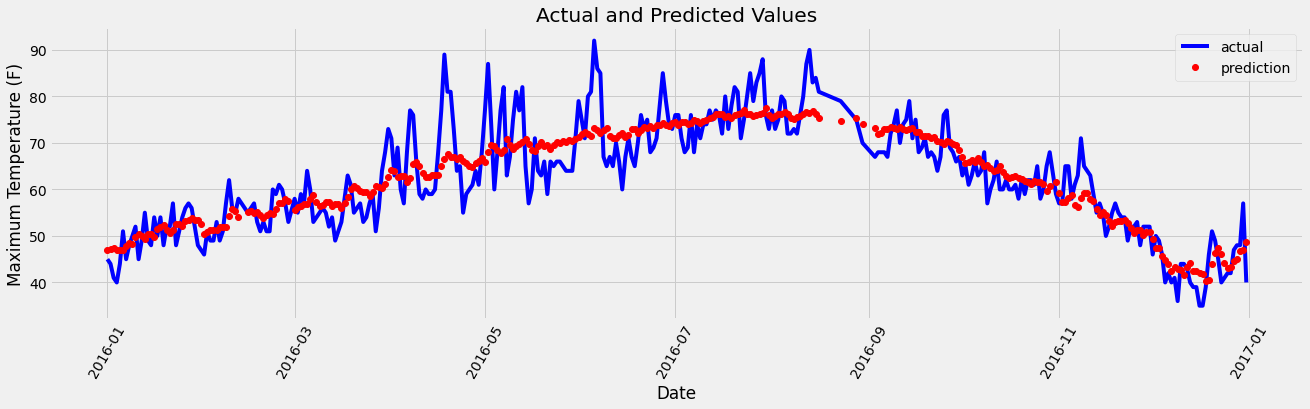

In [28]:
x = torch.tensor(input_features, dtype=torch.float)

# 转换成numpy格式便于画图
predict = my_nn(x).data.numpy()

# 转换日期格式
dates = [
    str(int(year)) + '-' + str(int(month)) + '-' + str(int(day))
    for year, month, day in zip(years, months, days)
]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data={'date': dates, 'actual': labels})

# 同理，再创建一个来存日期和其对应的模型预测值
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

test_dates = [
    str(int(year)) + '-' + str(int(month)) + '-' + str(int(day))
    for year, month, day in zip(years, months, days)
]

test_dates = [
    datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates
]

predictions_data = pd.DataFrame(data={
    'date': test_dates,
    'prediction': predict.reshape(-1)
})

plt.figure(figsize=(20,5))

# 真实值
plt.plot(true_data['date'], true_data['actual'], 'b-', label='actual')

# 预测值
plt.plot(predictions_data['date'],
         predictions_data['prediction'],
         'ro',
         label='prediction')
plt.xticks(rotation='60')
plt.legend()

# 图名
plt.xlabel('Date')
plt.ylabel('Maximum Temperature (F)')
plt.title('Actual and Predicted Values')
